# Computer Software Capstone PBL (Deep Learning for Computer Vision)

- **Instructor**: Jongwoo Lim / Jongbin Ryu
- **Email**: [jlim@hanyang.ac.kr](mailto:jlim@hanyang.ac.kr)
- **Time**: WED 17-19 / THU 16-18
- **Place**: IT/BT 402 / 607

## MNIST Example

In this example you will practice a simple neural network written by [PyTorch](https://pytorch.org), using the basically used handwritten digits data set, [MNIST Dataset](http://yann.lecun.com/exdb/mnist). The goals of this example are as follows:

- Learn basically how to **write and use code**(*PyTorch*).
- Understand **Neural Networks** and how they work.

*If you are more familiar with TensorFlow(or Keras), We'll see if We can help you in other ways. But PyTorch is still a good choice for beginners(or expert also).*

And this example also is written in [IPython Notebook](https://ipython.org/notebook.html), an interactive computational environment, in which you can run code directly.

### Environments

In this assignment, we assume the follows environments. 
The [Python](https://www.python.org) is a programming language that lets you work quickly and integrate systems more effectively. It is widely used in various fields, and also used in machine learning.
The [Pytorch](https://pytorch.org) is an open source deep learning platform, provides a seamless path from research to production.
The [CUDA®](https://developer.nvidia.com/cuda-zone) Toolkit provides high-performance GPU-accelerated computation. In deep learning, the model takes an age to train without GPU-acceleration. ~~even with the GPU, it still takes a lot of time~~.


- [Python3](https://www.python.org/downloads/) (recommend 3.6 or above)
- [PyTorch](https://pytorch.org) (recommend 1.0)
- [NumPy](http://www.numpy.org) the fundamental package for scientific computing with Python


- (Optional) [Anaconda](https://www.anaconda.com/distribution/#download-section), *popular Python Data Science Platform*
- (Optional) [TensorFlow](https://www.tensorflow.org/install), but examples are provided as PyTorch
- (Optional) [Jupyter](https://jupyter.org/) (Notebook or Lab)
- (Optional) [CUDA](https://developer.nvidia.com/cuda-downloads) support GPU


Python packages can install by `pip install [package name]` or using **Anaconda** by `conda install [package name]`.

*If you are having trouble installing or something else, please contact TA or jiun.maydev@gmail.com.*

# Code

### Import packages

First of all, Import some packages for using PyTorch.

- torch.nn: The **Network** of PyTorch basically starts with nn.Module.
- torch.nn.functional: for **Functions** such as *ReLU*, *MaxPool* (in this example)
- torch.optim: for **Optimizers**
- torchvision: Handling **Datasets**

Numpy the basic scientific computing package used in customary.

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Dataset

PyTorch basically provides MNIST Dataset and support download in running code!

In [2]:
DATASET_DIR = './data' # path to download mnist dataset

TRAIN_DATASET = datasets.MNIST(DATASET_DIR,   # Dataset root path
                               train=True,    # Train data
                               download=True) # Download if not exist

TEST_DATASET = datasets.MNIST(DATASET_DIR,    # Dataset root path
                              train=False)    # Test data

### (Optional) Visualize MNIST Dataset

This code is just show MNIST data (code is not important!)

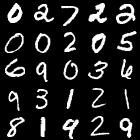

In [3]:
from PIL import Image  # PIL is Python Image Library 

n = 5                  # 5 x 5 matrix
size = 28              # Each image is 28 x 28

result = Image.new('L', (size * n, size * n))
for i, idx in enumerate(np.random.choice(len(TRAIN_DATASET), n * n)):
    x = i // n * size
    y = i % n * size
    result.paste(TRAIN_DATASET[idx][0], (x, y, x + size, y + size))
    
result

## Network

This is a simple two convolution layer network. The code is quite easy.
Just fallow `forward` function. `torch.nn.functional` and `torch.nn` support many useful function and layer for build network.
(See offical [doc](https://pytorch.org/docs/stable/nn.html#torch-nn-functional) for more information)

`nn.Conv2d` is 2-dimentional convolutaion layer.

`nn.Linear` is linear transformation as `y=ax+b`.

`F.relu` apply ReLU activation function.

`F.max_pool2d` apply 2-dimentional max-pooling.

So, whole network architecture as follow:

- Conv1 (input: 1, output: 20, kernel: 5, stride: 1)
- ReLU
- MaxPool
- Conv2 (input: 20, output: 50, kernel: 5, stride: 1)
- ReLU
- MaxPool
- FC1 (input: 4x4x50, output: 500)
- ReLU
- FC2 (input: 500, output: 10, class number of digit)


In [4]:
class Network(nn.Module):
    """Simple Neural Network contains conv layer and fc layer
    """
    def __init__(self):
        super(Network, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4 * 4 * 50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

## Define Train and Test functions

In train scope, we put the data to model, compute loss and update parameters. That's all we have to do.
To put data into the model, you call the model as a function that takes data as arguments. (see `output = model(data)`)
**PyTorch** provide many loss function. `nll_loss` is the *negative log likelihood loss*. compute loss using output and target(label).
Calling `.backward()` accumulates the gradient for each parameters.
Finally, call `optimizer.step()` to update optimizer.


In test scope, evaluate model using test set which not contained in a train set.
`pred = output.argmax(dim=1, keepdim=True)` is change output to digit-class for comparing to target(label).
`pred.eq(target.view_as(pred)).sum().item()` calculate correct answer count.


`model.train` and `model.test` means set `model` for train or test. In train scope set parameters trainable and test scope not update parameters.
So, if you want to update parameters, must call `model.train` before pass data to the model.

*`data.to(device)` and `target.to(device)` mean change data to device(gpu if available else cpu)*

In [5]:
from typing import Tuple

def train(model, device, train_loader, optimizer) -> float:
    """Train function

        Arguments:
            model (nn.Module): some networks extends from ``nn.Module``.
            device (torch.device): device for use CUDA if available.
            train_loader (torch.utils.data.dataloader.DataLoader): train data loader.
            optimizer (torch.optim): optimizer

        Returns: loss (float)
    """
    model.train()

    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()

    return loss.item()


def test(model, device, test_loader) -> Tuple[float, float, torch.Tensor]:
    """Test function

        Arguments:
            model (nn.Module): some networks extends from ``nn.Module``.
            device (torch.device): device for use CUDA if available.
            test_loader (torch.utils.data.dataloader.DataLoader): test data loader.

        Returns: tuple of below three
            test_loss: 
            accuracy: 
            output: 
    """
    model.eval()
    test_loss, correct = 0, 0
    
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)

    return test_loss, accuracy, output

## Run!


### Reproducible (**Important**)

**Reproducible** is very **very** ***very*** important in experiment. An experiment that can not be reproduced can not make any conclusions. So fix random seed before anything else.
In **PyTorch** just call `torch.manual_seed` for fix random seed. It will set the seed of the random generator, so random results will be **reproducible**.


### Hyperparameters

Unfortunately, machine learning does not mean learning all the variables. We call these parameters the **hyperparameters** that need to be set before learning.
In this example, we can set the *learning rate* before training.


### DataLoader

Loading files from disk is a very expensive operation. Especially in machine learning where a lot of training data is needed, also especially if each data is an image.
So, many frameworks provide *data loader* for effectively load data such as use multiple threads and cache. In **PyTorch** DataLoader support shuffle, batch slice, transform and many other functions.
But in this example, just use `batch_size` and `shuffle`.

PyTorch only process `torch.Tensor`. So, must convert data (3d numpy array) to tensor (torch.Tensor) using transform before training(or test).
*`transforms.ToTensor()` automatically transform data to tensor when loader called*


### GPU or CPU

`device` variable use **CUDA** if available. CPU can get results fast enough because there are fewer data and the network is simple. But when more data is available and the network gets more complicated, it's time to get help from the GPU. So now you do not have to worry.
Later `.to (device)` means use the device we specified.


### Build Network

`model = Network()` create network we defined before. In this example, we use [SGD(Stochastic gradient descent)](https://en.wikipedia.org/wiki/Stochastic_gradient_descent) optimizer.

In [6]:
torch.manual_seed(42) # 42, THE ANSWER TO LIFE, THE UNIVERSE AND EVERYTHING

batch = 64            # batch size
lr = .01              # learning rate
epochs = 10


TRAIN_DATASET.transform = transforms.ToTensor()
train_loader = torch.utils.data.DataLoader(TRAIN_DATASET,
                                           batch_size=64,
                                           shuffle=True)

TEST_DATASET.transform = transforms.ToTensor()
test_loader = torch.utils.data.DataLoader(TEST_DATASET,
                                          batch_size=64,
                                          shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = Network().to(device)
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(1, epochs + 1):
    train_loss = train(model, device, train_loader, optimizer)
    test_loss, accuracy, _ = test(model, device, test_loader)
    
    print('Epoch: {}\t Loss: {:.6f}'.format(epoch, train_loss))
    print('\t\t Average Loss: {:.4f}, Accuracy: {:.0f}%'.format(test_loss, accuracy))

torch.save(model.state_dict(), "mnist_cnn.pt")  # save trained model named 'mnist_cnn.pt'

Epoch: 1	 Loss: 0.272287
		 Average Loss: 0.3230, Accuracy: 90%
Epoch: 2	 Loss: 0.094143
		 Average Loss: 0.1781, Accuracy: 95%
Epoch: 3	 Loss: 0.168488
		 Average Loss: 0.1276, Accuracy: 96%
Epoch: 4	 Loss: 0.057999
		 Average Loss: 0.0949, Accuracy: 97%
Epoch: 5	 Loss: 0.119081
		 Average Loss: 0.0960, Accuracy: 97%
Epoch: 6	 Loss: 0.068059
		 Average Loss: 0.0846, Accuracy: 97%
Epoch: 7	 Loss: 0.007233
		 Average Loss: 0.0591, Accuracy: 98%
Epoch: 8	 Loss: 0.135408
		 Average Loss: 0.0627, Accuracy: 98%
Epoch: 9	 Loss: 0.055459
		 Average Loss: 0.0527, Accuracy: 98%
Epoch: 10	 Loss: 0.006912
		 Average Loss: 0.0459, Accuracy: 99%
